# Lecture 21 - LINEAR DATA FITTING WITH UNCERTANTIES - HW 9

As scientists one of our many checks is to fit data to models.  Here, we will begin first by learning how to fit data with uncertanties to a linear fit (slope and intercept, and uncertanties) by using the python `scipy` module. 

In [2]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [4]:
#Read in the data to a numpy array
data = np.genfromtxt("LinearFit_data.txt", names=True, dtype=None)

# print out all columns we just got for free
data.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

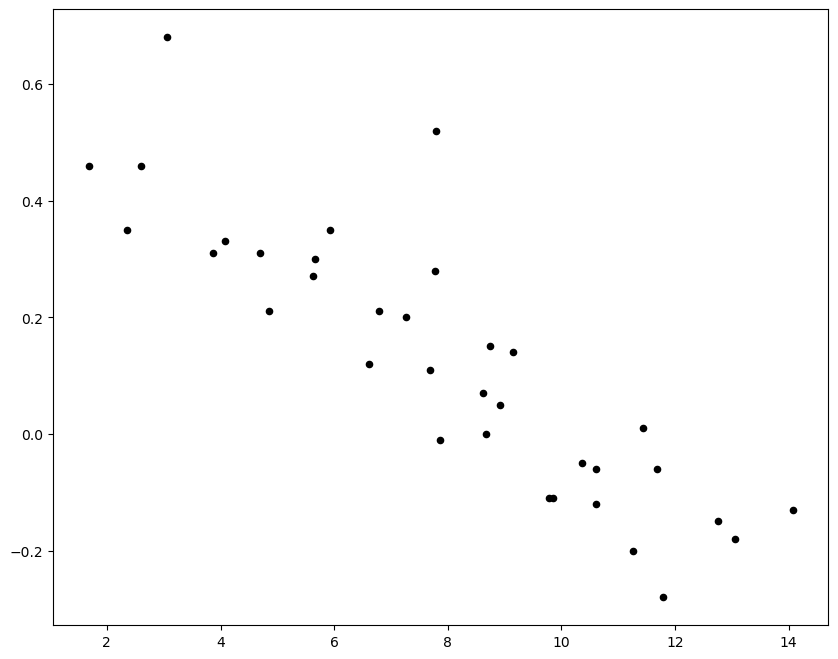

In [6]:
#First let's see what this data looks like
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [8]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.061902193399352975 0.6174204495463552
raw:  [ 3.63943119e-05 -2.88586096e-04] [-0.00028859  0.0026655 ]


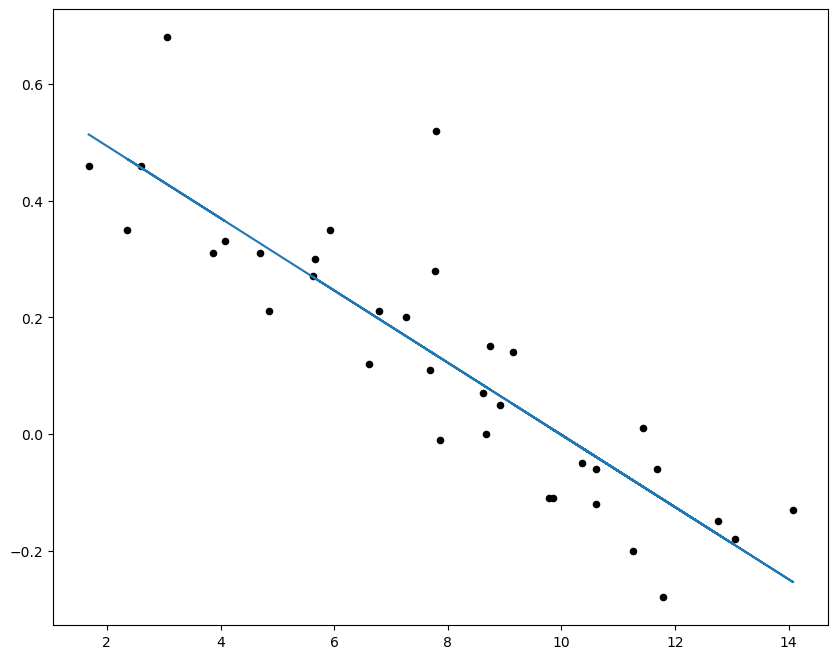

In [10]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


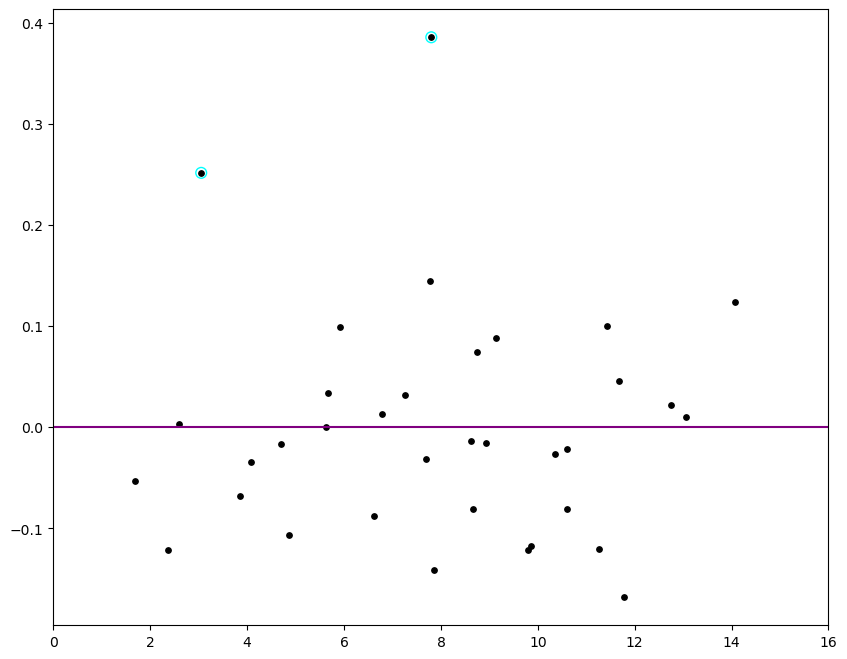

In [12]:
#Let's look into wich data are way off the fit.

residual = data['Y']-linear(data['X'],*popt)
x = np.linspace(0,20,1000)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(0,16)

outlier = np.absolute(residual)>0.20
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  -0.061902193399352975 0.6174204495463552
outliers accounted for:  -0.0581318237215009 0.5703220759875326


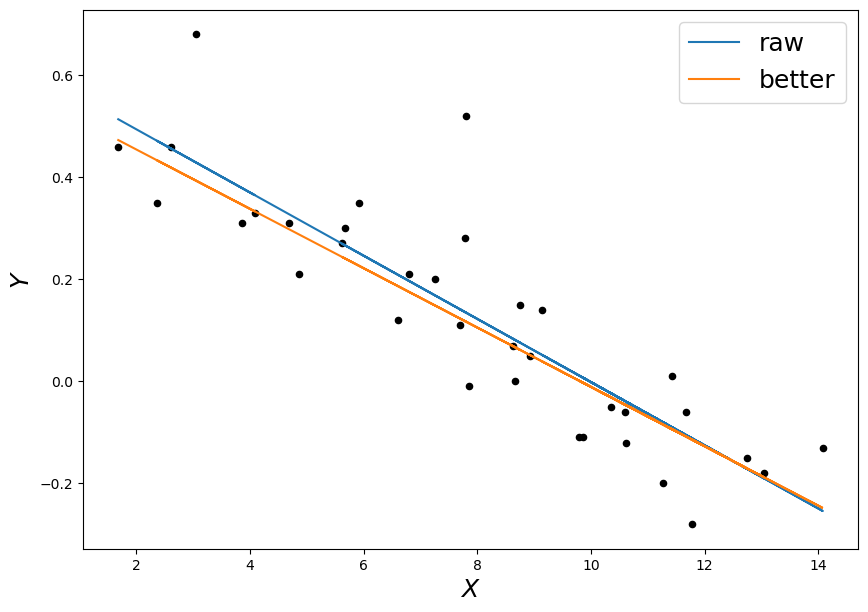

In [14]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.056065582982940974 0.5500877321369341


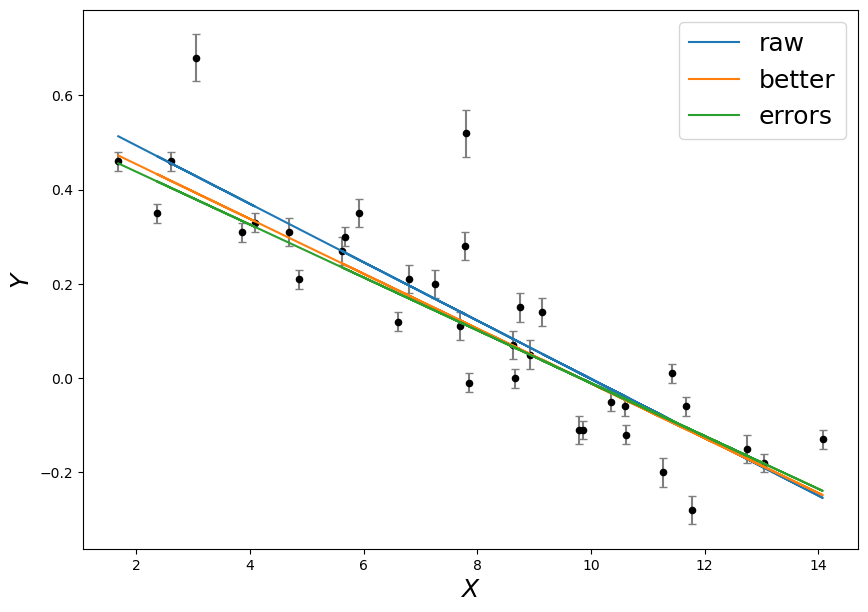

In [16]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0619, mean intercept: 0.6177


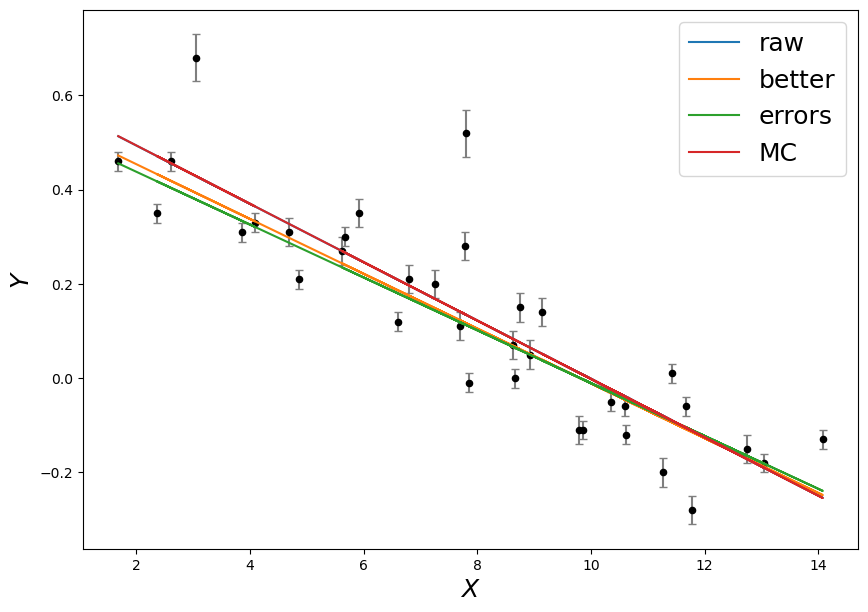

In [18]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [20]:
# oh right, those outliers.

mask = data['Y'] < 0.5 

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/dv/15qgfvwx1svb99gs13v12tj00000gn/T/ipykernel_28680/2451819757.py:13: SyntaxWarning: invalid escape sequence '\p'
  print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
/var/folders/dv/15qgfvwx1svb99gs13v12tj00000gn/T/ipykernel_28680/2451819757.py:19: SyntaxWarning: invalid escape sequence '\p'
  print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope),


data size:  33
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.5649


slope: -0.0578 $\pm$ 0.0011, mean intercept: 0.5646
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5656
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5657
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5651
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.5647
slope: -0.0579 $\pm$ 0.0013, mean intercept: 0.5654
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.5652
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5650
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.5650
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5652
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.5650
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.5648
slope: -0.0579 $\pm$ 0.0013, mean intercept: 0.5656
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5655
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.5652
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5649
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5662
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/dv/15qgfvwx1svb99gs13v12tj00000gn/T/ipykernel_28680/225136314.py:18: SyntaxWarning: invalid escape sequence '\p'
  ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
/var/folders/dv/15qgfvwx1svb99gs13v12tj00000gn/T/ipykernel_28680/225136314.py:19: SyntaxWarning: invalid escape sequence '\p'
  ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)


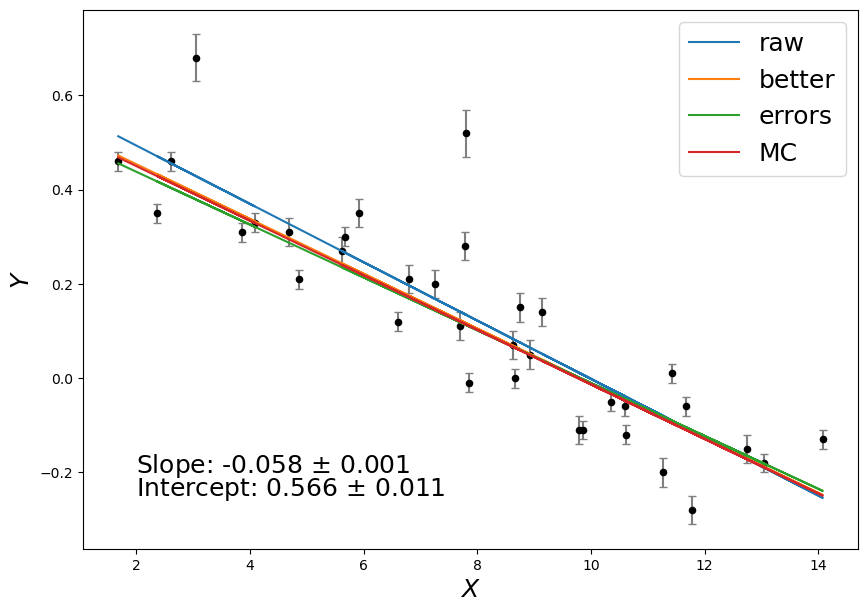

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

## Homework #10

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_23_HW10.ipynb

### Problem 1:
We can't know the x data perfectly suppose the data have uniform x errors of 0.5 use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors.



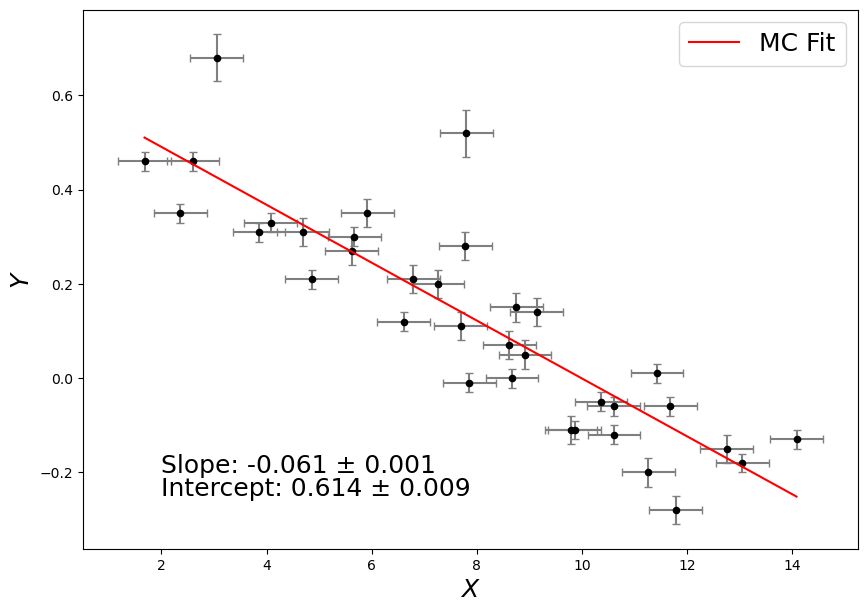

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

x_errors = 0.5  
n_iterations = 10000 

slopes = []
intercepts = []

for _ in range(n_iterations):
    x_noisy = data['X'] + np.random.uniform(-x_errors, x_errors, size=data['X'].shape)
    
    slope, intercept, _, _, _ = linregress(x_noisy, data['Y'])
    
    slopes.append(slope)
    intercepts.append(intercept)

mean_slope = np.mean(slopes)
mean_intercept = np.mean(intercepts)
slope_uncertainty = np.std(slopes)
intercept_uncertainty = np.std(intercepts)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.scatter(data['X'], data['Y'], s=20, c='black', zorder=2)
ax.errorbar(data['X'], data['Y'], yerr=data['Y_ERR'], xerr= .5, c='tab:gray', 
            fmt='.', markersize=1, capsize=3, zorder=0)

x_fit = np.linspace(min(data['X']), max(data['X']), 100)
y_fit = mean_slope * x_fit + mean_intercept

ax.plot(x_fit, y_fit, label='MC Fit', color='red')

ax.text(2, -0.2, "Slope: {:+5.3f} ± {:5.3f}".format(mean_slope, slope_uncertainty), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} ± {:5.3f}".format(mean_intercept, intercept_uncertainty), fontsize=18)

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)
plt.legend(loc='best', fontsize=18)

plt.show()


### Problem 2:
Repeat problem #1 , but change the errors INCREASE as we move away from X = 8 (as they do) to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit.

Plot both slopes (Problem 1 & 2). How does the fit change? 

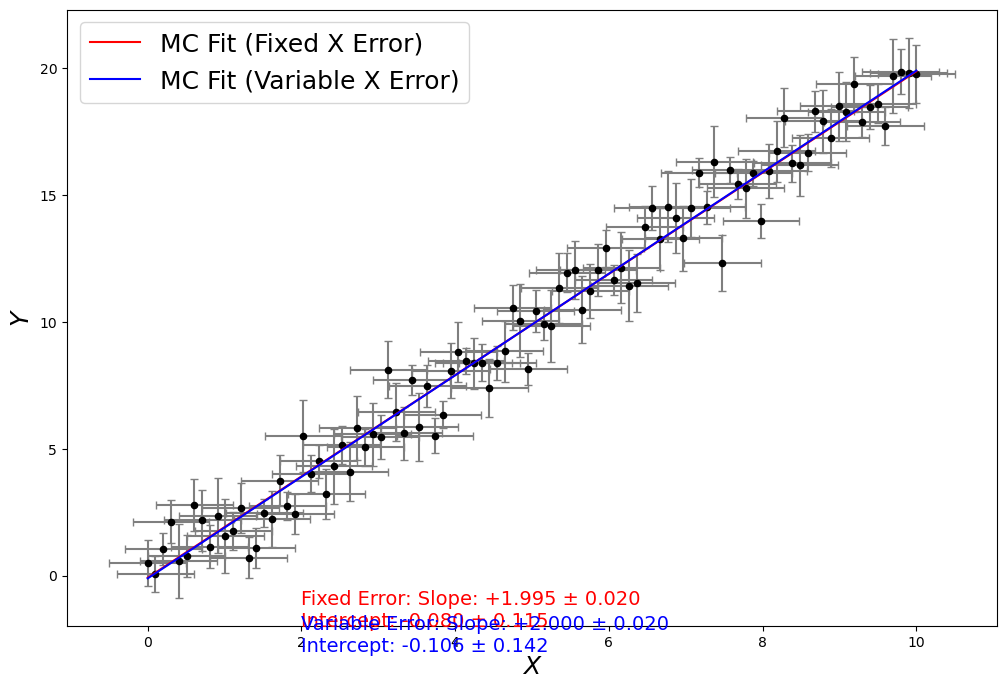

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

np.random.seed(42)
data_size = 100
x_values = np.linspace(0, 10, data_size)
y_values = 2 * x_values + np.random.normal(0, 1, data_size)  
y_errors = np.random.uniform(0.5, 1.5, size=data_size)  
data = {'X': x_values, 'Y': y_values, 'Y_ERR': y_errors}

x_errors_fixed = 0.5  
n_iterations = 10000 

slopes_fixed = []
intercepts_fixed = []

x_errors_variable = np.abs(data['X'] - 8) / 10

for _ in range(n_iterations):
    x_noisy_fixed = data['X'] + np.random.uniform(-x_errors_fixed, x_errors_fixed, size=data['X'].shape)
    slope, intercept, _, _, _ = linregress(x_noisy_fixed, data['Y'])
    slopes_fixed.append(slope)
    intercepts_fixed.append(intercept)

slopes_variable = []
intercepts_variable = []

for _ in range(n_iterations):
    x_noisy_variable = data['X'] + np.random.uniform(-x_errors_variable, x_errors_variable, size=data['X'].shape)
    slope, intercept, _, _, _ = linregress(x_noisy_variable, data['Y'])
    slopes_variable.append(slope)
    intercepts_variable.append(intercept)

mean_slope_fixed = np.mean(slopes_fixed)
mean_intercept_fixed = np.mean(intercepts_fixed)
slope_uncertainty_fixed = np.std(slopes_fixed)
intercept_uncertainty_fixed = np.std(intercepts_fixed)

mean_slope_variable = np.mean(slopes_variable)
mean_intercept_variable = np.mean(intercepts_variable)
slope_uncertainty_variable = np.std(slopes_variable)
intercept_uncertainty_variable = np.std(intercepts_variable)

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(data['X'], data['Y'], s=20, c='black', zorder=2)
ax.errorbar(data['X'], data['Y'], yerr=data['Y_ERR'], xerr=x_errors_fixed, 
            c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)

x_fit = np.linspace(min(data['X']), max(data['X']), 100)
y_fit_fixed = mean_slope_fixed * x_fit + mean_intercept_fixed
y_fit_variable = mean_slope_variable * x_fit + mean_intercept_variable

ax.plot(x_fit, y_fit_fixed, label='MC Fit (Fixed X Error)', color='red')
ax.plot(x_fit, y_fit_variable, label='MC Fit (Variable X Error)', color='blue')

ax.text(2, -2, "Fixed Error: Slope: {:+5.3f} ± {:5.3f}\nIntercept: {:5.3f} ± {:5.3f}".format(mean_slope_fixed, slope_uncertainty_fixed, mean_intercept_fixed, intercept_uncertainty_fixed), fontsize=14, color='red')
ax.text(2, -3, "Variable Error: Slope: {:+5.3f} ± {:5.3f}\nIntercept: {:5.3f} ± {:5.3f}".format(mean_slope_variable, slope_uncertainty_variable, mean_intercept_variable, intercept_uncertainty_variable), fontsize=14, color='blue')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)
plt.legend(loc='best', fontsize=18)

plt.show()

### Problem 3: 
Repeat problem 1 & 2, but now anaylze for X vs. Z data, including both uniform 0.5 and X_ERR = |x - 8| /10 uncertainties.

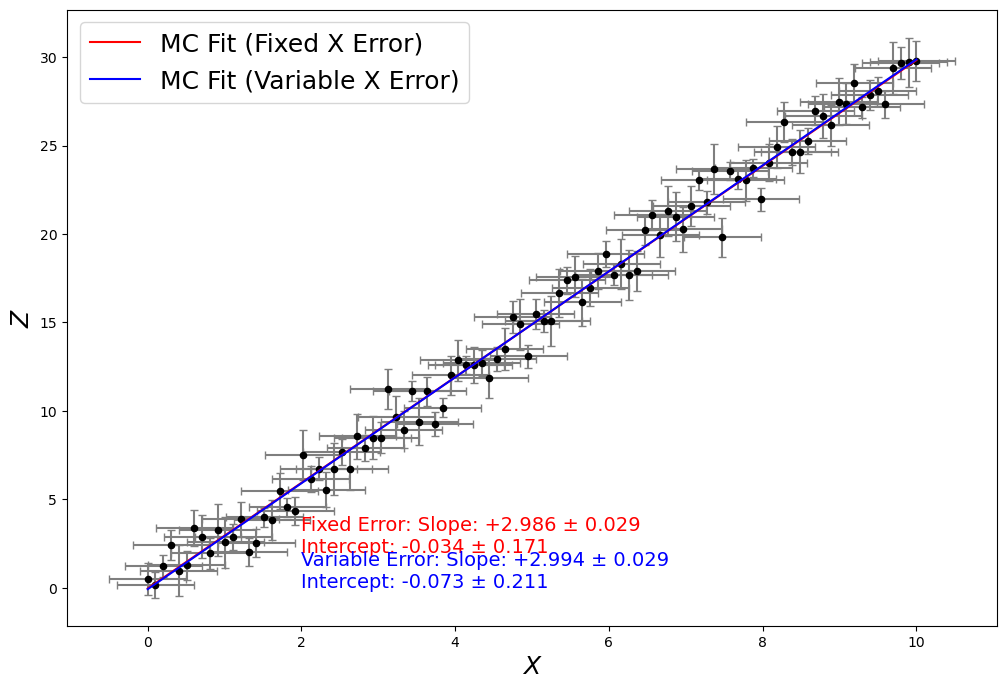

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


np.random.seed(42) 
data_size = 100
x_values = np.linspace(0, 10, data_size)
z_values = 3 * x_values + np.random.normal(0, 1, data_size)  
y_errors = np.random.uniform(0.5, 1.5, size=data_size) 
data = {'X': x_values, 'Z': z_values, 'Y_ERR': y_errors}

x_errors_fixed = 0.5  
n_iterations = 10000 

slopes_fixed = []
intercepts_fixed = []

x_errors_variable = np.abs(data['X'] - 8) / 10

for _ in range(n_iterations):
    x_noisy_fixed = data['X'] + np.random.uniform(-x_errors_fixed, x_errors_fixed, size=data['X'].shape)
    slope, intercept, _, _, _ = linregress(x_noisy_fixed, data['Z'])
    slopes_fixed.append(slope)
    intercepts_fixed.append(intercept)

slopes_variable = []
intercepts_variable = []

for _ in range(n_iterations):
    x_noisy_variable = data['X'] + np.random.uniform(-x_errors_variable, x_errors_variable, size=data['X'].shape)
    slope, intercept, _, _, _ = linregress(x_noisy_variable, data['Z'])
    slopes_variable.append(slope)
    intercepts_variable.append(intercept)

mean_slope_fixed = np.mean(slopes_fixed)
mean_intercept_fixed = np.mean(intercepts_fixed)
slope_uncertainty_fixed = np.std(slopes_fixed)
intercept_uncertainty_fixed = np.std(intercepts_fixed)

mean_slope_variable = np.mean(slopes_variable)
mean_intercept_variable = np.mean(intercepts_variable)
slope_uncertainty_variable = np.std(slopes_variable)
intercept_uncertainty_variable = np.std(intercepts_variable)

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(data['X'], data['Z'], s=20, c='black', zorder=2)
ax.errorbar(data['X'], data['Z'], yerr=data['Y_ERR'], xerr=x_errors_fixed, 
            c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)

x_fit = np.linspace(min(data['X']), max(data['X']), 100)
y_fit_fixed = mean_slope_fixed * x_fit + mean_intercept_fixed
y_fit_variable = mean_slope_variable * x_fit + mean_intercept_variable

ax.plot(x_fit, y_fit_fixed, label='MC Fit (Fixed X Error)', color='red')
ax.plot(x_fit, y_fit_variable, label='MC Fit (Variable X Error)', color='blue')

ax.text(2, 2, "Fixed Error: Slope: {:+5.3f} ± {:5.3f}\nIntercept: {:5.3f} ± {:5.3f}".format(mean_slope_fixed, slope_uncertainty_fixed, mean_intercept_fixed, intercept_uncertainty_fixed), fontsize=14, color='red')
ax.text(2, 0, "Variable Error: Slope: {:+5.3f} ± {:5.3f}\nIntercept: {:5.3f} ± {:5.3f}".format(mean_slope_variable, slope_uncertainty_variable, mean_intercept_variable, intercept_uncertainty_variable), fontsize=14, color='blue')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)
plt.legend(loc='best', fontsize=18)

plt.show()
